In [39]:
import scipy.io as sio
import pandas as pd
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import scipy.signal
from fooof import FOOOF
from neurodsp.filt import filter_signal
from scipy import signal


# Load CSV with metadata
os.chdir('/Users/alissavalentine/ephys_rotation')
meta_data = pd.read_csv('qc_depth_duration.csv')
# meta_data = pd.read_csv('depth_duration.csv')

In [40]:
file_paths = []
# saving files in h5py
for path in meta_data.file_path:
    mat_data = sio.loadmat(path)
    key = list(mat_data.keys())[3]
    data_structure = mat_data[key] # returns numpy nd array with values within the data structure A,b,c etc.
    data_structure = data_structure[0][0]
    continuous_channel = data_structure[-3]
    continuous_channel = continuous_channel[0][0]
    data = continuous_channel[-1]
    new_path = path.replace("MATfiles", "HDF5files").split('.mat')[0] + '.hdf5'
    new_path = path.split('/')[-1].split('.mat')[0] + '.hdf5'
    file_paths.append(new_path)
    # print(path, new_path)
    os.chdir('/Users/alissavalentine/ephys_rotation/hdf5')
    f = h5py.File(new_path, "w")
    f.create_dataset('data', data=data[:, 0], dtype='<i2')
    f.close()

In [ ]:
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times
from fooof.plts.spectra import plot_spectrum
f_range = (2,50)

for file in file_paths:
    with h5py.File(file, "r") as f:
        FILE_NAME = file.split('.hdf5')[0].replace(".", "_")
        raw_signal = np.array(f.get('data'), dtype=np.float64)
        sr = 48000 # because i know this
        filt_signal = filter_signal(raw_signal, sr, 'bandpass', range)
        filt_signal = np.array([x for x in filt_signal if np.isnan(x) == False])
        secs = len(filt_signal)/sr # Number of seconds in signal X
        samps = int(secs*1000)     # Number of samples to downsample
        down_filt_signal = scipy.signal.resample(filt_signal, samps)
        # times = create_times((len(filt_signal)/sr), sr)
        # plot_time_series(times, raw_signal, ['Raw'])
        # plot_time_series(times, filt_signal, ['Filtered'])
        freqs, powers = compute_spectrum(down_filt_signal, 1000, f_range = range)
        #plot_spectrum(freqs, powers, log_powers=True)
        # Initialize a FOOOF object
        fm = FOOOF(peak_width_limits= [2,7],min_peak_height=0.05, max_n_peaks = 3, verbose=True)
        fm.fit(freqs, powers)
        fm.report(freqs, powers, [5, 45])
        fm.save_report(file_name= FILE_NAME, file_path='/Users/alissavalentine/ephys_rotation/hdf5/reports/')


In [41]:
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times
from fooof.plts.spectra import plot_spectrum
from fooof import FOOOF
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fm

# file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset
final_values = []
range = (2,50)
sr = 48000 # because i know this

for file in file_paths:
    #if "VIM" in file:
    with h5py.File(file, "r") as f:
        raw_signal = np.array(f.get('data'), dtype=np.float64)
        filt_signal = filter_signal(raw_signal, sr, 'bandpass', range)
        filt_signal = np.array([x for x in filt_signal if np.isnan(x) == False])
        secs = len(filt_signal)/sr # Number of seconds in signal X
        samps = int(secs*1000)     # Number of samples to downsample
        down_filt_signal = scipy.signal.resample(filt_signal, samps)
        # print(type(filt_signal), filt_signal[0])
        #times = create_times((len(filt_signal)/sr), sr)
        # plot_time_series(times, raw_signal, ['Raw'])
        # plot_time_series(times, filt_signal, ['Filtered'])
        freqs, powers = compute_spectrum(down_filt_signal, 1000, f_range = range)
        #plot_spectrum(freqs, powers, log_powers=True)
        bands = Bands({'theta' : [4, 8], 'alpha' : [8, 13], 'beta' : [13, 30], 'low_gamma' : [30, 50]})
        # Initialize a FOOOF object
        fm = FOOOF(peak_width_limits= [2,7],min_peak_height=0.05, max_n_peaks = 3, verbose=True)
        fm.fit(freqs, powers)
        #fm.report(freqs, powers, [5, 45])
        theta = get_band_peak_fm(fm, bands.theta)
        theta_CF = theta[0]
        theta_PW = theta[1]
        theta_BW = theta[2]
        alpha = get_band_peak_fm(fm, bands.alpha)
        alpha_CF = alpha[0]
        alpha_PW = alpha[1]
        alpha_BW = alpha[2]
        beta = get_band_peak_fm(fm, bands.beta)
        beta_CF = beta[0]
        beta_PW = beta[1]
        beta_BW = beta[2]
        low_gamma = get_band_peak_fm(fm, bands.low_gamma)
        low_gamma_CF = low_gamma[0]
        low_gamma_PW = low_gamma[1]
        low_gamma_BW = low_gamma[2]
        #print(theta, alpha, beta, low_gamma)
        error = fm.get_params('error')
        r_squared = fm.get_params('r_squared')
        exponent = fm.get_params('aperiodic_params')[1]
        offset = fm.get_params('aperiodic_params')[0]
        path = file.rsplit("/")[-1].rstrip('.hdf5')
        new_data = str(path + "," + str(theta_CF) + "," + str(theta_PW) + "," + str(theta_BW)  + "," + str(alpha_CF) + "," + str(alpha_PW) + "," + str(alpha_BW) + "," + str(beta_CF) + "," + str(beta_PW) + "," + str(beta_BW) + "," + str(low_gamma_CF) + "," + str(low_gamma_PW) + "," + str(low_gamma_BW)  + "," + str(r_squared)+ "," + str(error) + "," + str(exponent)+ "," + str(offset))
        final_values.append(new_data)


all_file = open("ALL_analyses_updated.txt", "w")
with all_file as file:
    file.writelines("file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset\n")
    for line in final_values:
        file.writelines(str(line))
        file.writelines("\n")
all_file.close()

In [38]:
# import os
# outdir = '/Users/alissavalentine/ephys_rotation'
# os.chdir(outdir)

# STN_file = open("STN_analyses_updated.txt", "w")
# with STN_file as file:
#     file.writelines("file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset\n")
#     for line in final_values:
#         file.writelines(str(line))
#         file.writelines("\n")
# STN_file.close()

# GPi_file = open("GPi_analyses.txt", "w")
# with GPi_file as file:
#     file.writelines("file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset\n")
#     for line in final_values:
#         file.writelines(str(line))
#         file.writelines("\n")
# GPi_file.close()

VIM_file = open("VIM_analyses_updated.txt", "w")
with VIM_file as file:
    file.writelines("file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset\n")
    for line in final_values:
        file.writelines(str(line))
        file.writelines("\n")
VIM_file.close()

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
[ 425.10555695 1231.54375803 1356.71063111 1109.72749438  969.6542404
  882.78638765  690.06066151  577.15864971  521.48358311  463.80105229
  457.06337822  459.23994964  457.16623618  443.70488902  410.26899103
  364.6021064   304.84011414  294.61486242  288.63529419  280.16855484
  270.32745005  252.30908672  221.56084602  184.11536451  157.82932771
  155.65278287  152.29535411  138.24782192  135.53764718  137.35218091
  124.58228709  107.5316896   104.2959601   101.31516393   98.88707079
  103.25753589  113.81862074  101.19827336   90.40924801   86.34753409
   88.3408155    94.68933386   79.5342652    60.69326206   62.78869547
   69.63095804   71.70109873   62.56844908   24.22270593]
[4. 5. 6. 7. 8.]
[1356.71063111 1109.72749438  969.6542404   882.78638765  690.06066151]
[3.04692432 2.9

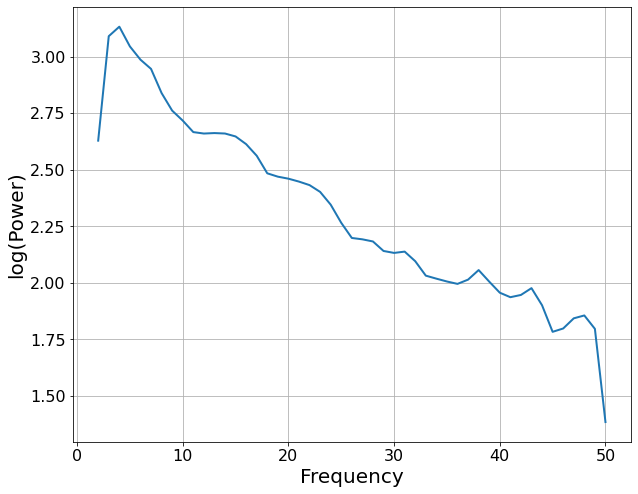

In [32]:
from neurodsp.spectral import compute_spectrum
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times
from fooof.plts.spectra import plot_spectrum
from fooof import FOOOF
from fooof.bands import Bands
from fooof.sim.gen import gen_aperiodic
from fooof.plts.annotate import plot_annotated_peak_search
from fooof.analysis import get_band_peak_fm
from fooof.plts.annotate import plot_annotated_model
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading

#file = '/Users/alissavalentine/ephys_rotation/hdf5/PT-0017_STNLeft_Pass1_R1C_Snapshot-30.0sec2_R-3.71.hdf5'
file = '/Users/alissavalentine/ephys_rotation/hdf5/PT-0017_STNLeft_Pass1_R1C_Snapshot-30.0sec1_R-3.81.hdf5'
range = (2,50)

# file_name,theta_CF,theta_PW,theta_BW,alpha_CF,alpha_PW,alpha_BW,beta_CF,beta_PW,beta_BW,lgamma_CF,lgamma_PW,lgamma_BW,Rsquare,error,exponent,offset
final_values = []

with h5py.File(file, "r") as f:
        raw_signal = np.array(f.get('data'), dtype=np.float64)
        sr = 48000 # because i know this
        filt_signal = filter_signal(raw_signal, sr, 'bandpass', range)
        filt_signal = np.array([x for x in filt_signal if np.isnan(x) == False])
        secs = len(filt_signal)/sr # Number of seconds in signal X
        samps = int(secs*1000)     # Number of samples to downsample
        down_filt_signal = scipy.signal.resample(filt_signal, samps)
        # print(type(filt_signal), filt_signal[0])
        # times2 = create_times((len(raw_signal)/sr), sr)
        # times = create_times((len(down_filt_signal)/1000), 1000)
        # plot_time_series(times2, raw_signal, ['Raw'])
        # plot_time_series(times, down_filt_signal, ['Filtered'])
        freqs, powers = compute_spectrum(down_filt_signal, 1000, f_range = range)
        plot_spectrum(freqs, powers, log_powers=True)
        bands = Bands({'theta' : [4, 8], 'alpha' : [8, 13], 'beta' : [13, 30], 'low_gamma' : [30, 50]})
        # Initialize a FOOOF object
        fm = FOOOF(peak_width_limits= [2,7],min_peak_height=0.05, max_n_peaks = 3, verbose=True)
        fm.fit(freqs, powers)
        #fm.report(freqs, powers, [5, 45])
        print(freqs)
        print(powers)
        print(freqs[2:7])
        print(powers[2:7])
        print(fm.fooofed_spectrum_)

        init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
        init_flat_spec = fm.power_spectrum - init_ap_fit
        # Plot the flattened the power spectrum
        # plot_spectrum(fm.freqs, init_flat_spec,  label='Flattened Spectrum', color='black')
        # plot_annotated_peak_search(fm)
        # plot_spectrum(fm.freqs, fm._spectrum_peak_rm, label='Peak Removed Spectrum', color='black')
        # plot_spectrum(fm.freqs, fm._ap_fit, label='Final Aperiodic Fit', color='blue', alpha=0.5, linestyle='dashed')
        print(fm._ap_fit)
        print(init_flat_spec)
        print(fm._spectrum_flat)
        print(init_ap_fit)
        # plot_annotated_model(fm, plt_log=False)
        # plot_spectrum_shading(freqs, powers, [[4, 8], [8, 13], [13,30], [30,50]],
        #              log_powers=True, shade_colors=['pink', 'yellow','green', 'blue'])
        # theta = get_band_peak_fm(fm, bands.theta)
        # theta_CF = theta[0]
        # theta_PW = theta[1]
        # theta_BW = theta[2]
        # alpha = get_band_peak_fm(fm, bands.alpha)
        # alpha_CF = alpha[0]
        # alpha_PW = alpha[1]
        # alpha_BW = alpha[2]
        # beta = get_band_peak_fm(fm, bands.beta)
        # beta_CF = beta[0]
        # beta_PW = beta[1]
        # beta_BW = beta[2]
        # low_gamma = get_band_peak_fm(fm, bands.low_gamma)
        # low_gamma_CF = low_gamma[0]
        # low_gamma_PW = low_gamma[1]
        # low_gamma_BW = low_gamma[2]
        # print(theta, alpha, beta, low_gamma)
        # r_squared = fm.get_params('r_squared')
        # error = fm.get_params('error')
        # exponent = fm.get_params('aperiodic_params')[1]
        # offset = fm.get_params('aperiodic_params')[0]
        # path = file.rsplit("/")[-1].rstrip('.hdf5')
        # new_data = str(path + "," + str(theta_CF) + "," + str(theta_PW) + "," + str(theta_BW)  + "," + str(alpha_CF) + "," + str(alpha_PW) + "," + str(alpha_BW) + "," + str(beta_CF) + "," + str(beta_PW) + "," + str(beta_BW) + "," + str(low_gamma_CF) + "," + str(low_gamma_PW) + "," + str(low_gamma_BW)  + "," + str(r_squared)+ "," + str(error) + "," + str(exponent)+ "," + str(offset))
        # final_values.append(new_data)
        #print(exponent, r_squared)
        #fm.save_report(file_name="test", file_path='/Users/alissavalentine/ephys_rotation/hdf5/reports/')
        #fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})
        # Report: fit the model, print the resulting parameters, and plot the reconstruction

# print(final_values)

In [25]:
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectrum
from fooof.plts.annotate import plot_annotated_model

# Set random seed, for consistency generating simulated data
set_random_seed(21)

# Simulate example power spectra
freqs1, powers1 = gen_power_spectrum([3, 40], [1, 1],
                                     [[10, 0.2, 1.25], [30, 0.15, 2]])
freqs2, powers2 = gen_power_spectrum([1, 150], [1, 125, 1.25],
                                     [[8, 0.15, 1.], [30, 0.1, 2]])

fm1 = FOOOF(min_peak_height=0.05, verbose=False)
fm2 = FOOOF(min_peak_height=0.05, aperiodic_mode='knee', verbose=False)
fm1.fit(freqs1, powers1)
fm2.fit(freqs2, powers2)

print(type(freqs1), type(powers1), freqs1.shape, powers1.shape)

# # Plot one of the example power spectra
# fm1.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'})
# plot_spectrum(freqs2, powers2, log_powers=True,
#               color='black', label='Original Spectrum')
# plot_annotated_model(fm1, annotate_aperiodic=False, annotate_peaks=False, plt_log=True)
# fm1.report(freqs1, powers2, freq_range=[2, 40])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (75,) (75,)


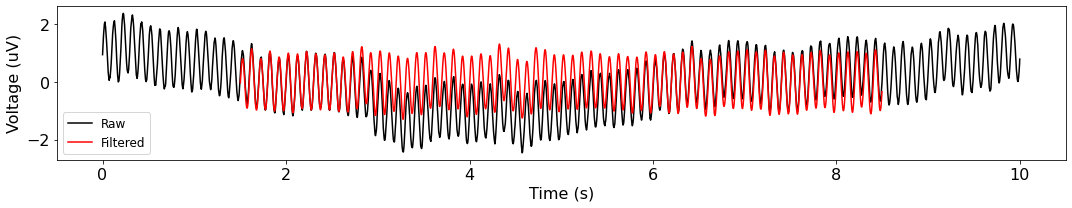

In [55]:
from neurodsp.sim import sim_combined

from neurodsp.utils import create_times
sig = sim_combined(n_seconds=10, fs=500,
                   components={'sim_powerlaw': {}, 'sim_oscillation' : {'freq': 10}})
filt_sig = filter_signal(sig, fs=500, pass_type='bandpass',
                         filter_type='fir', f_range=(1, 25))

times = create_times(10, 500)

plot_time_series(times, [sig, filt_sig], ['Raw', 'Filtered'])